In [70]:
from pathlib import Path
from tensorflow.keras.models import model_from_json

In [72]:
# load json and create model
file_path = Path("model_1_day.json")
with open(file_path, "r") as json_file:
    model_json = json_file.read()
loaded_model_1_day = model_from_json(model_json)

# load weights into new model
file_path = "model_1_day.h5"
loaded_model_1_day.load_weights(file_path)

In [73]:
def fetch_data():
    """Fetches the latest prices."""
   # Set Alpaca API key and secret

    alpaca_api_key = os.getenv("ALPACA_API_KEY")
    alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
    
    alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")
    today = date.today()
    start = date.today() - timedelta(days=600)

    # Set the tickers & timeframe
    tickers = ["SPY"]

    timeframe = "1D"

    #Get Closing prices for past 60 days

    df = alpaca.get_barset(
        tickers,
        timeframe,
        start = start,
        end = today
    ).df
    #figure out another way to clean and prep the data here - hard coded for now 
    df_clean = df['SPY']

    # Display sample data
    return df_clean

In [74]:
data = fetch_data()
data = data.reset_index()
data = data.set_index('time', drop=True)
data['close of tomorrow'] = data['close'].shift(-1)
data

,open,high,low,close,volume,close of tomorrow
time,,,,,,
2020-10-30 00:00:00-04:00,328.28,329.690,322.6000,326.530,93413096,330.210
2020-11-02 00:00:00-05:00,330.20,332.360,327.2400,330.210,69167640,335.970
2020-11-03 00:00:00-05:00,333.69,338.250,330.2935,335.970,74330624,343.495
2020-11-04 00:00:00-05:00,340.86,347.940,339.5900,343.495,101560371,350.210
2020-11-05 00:00:00-05:00,349.25,352.190,348.8600,350.210,67420157,350.190
...,...,...,...,...,...,...
2021-03-19 00:00:00-04:00,389.88,391.569,387.1500,389.500,93819590,392.540
2021-03-22 00:00:00-04:00,390.03,394.070,389.9700,392.540,61372559,389.590
2021-03-23 00:00:00-04:00,391.91,393.460,388.6600,389.590,78235945,387.550


In [75]:
#Calculate additional data to use as features - add to dataframe



def generate_ema_macd__RSI_signals(df):
    
    def EWMA(data, ndays):
        EMA = pd.Series(data['close'].ewm(span = ndays, min_periods = ndays - 1).mean(),
                     name = 'EWMA_' + str(ndays))
        data = data.join(EMA)
        return data

    def computeRSI (data, time_window):
        diff = data.diff(1).dropna()        # diff in one field(one day)

        #this preservers dimensions off diff values
        up_chg = 0 * diff
        down_chg = 0 * diff

        # up change is equal to the positive difference, otherwise equal to zero
        up_chg[diff > 0] = diff[ diff>0 ]

        # down change is equal to negative deifference, otherwise equal to zero
        down_chg[diff < 0] = diff[ diff < 0 ]

        # we set com=time_window-1 so we get decay alpha=1/time_window
        up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
        down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()

        rs = abs(up_chg_avg/down_chg_avg)
        rsi = 100 - 100/(1+rs)
        return rsi


    #Calculate RSI
    df['RSI'] = computeRSI (df['close'], 14)
    # Construct a buy and sell trading signals buy -1 sell - 0 -- Add more sophistication to this -- I wanted to have a signal that says buy when RSI is between 50 -70 or oversold and sell when overbought and RSI is between 30-50
    df['RSI Overbought'] = np.where(df['RSI'] > 70, 1.0, 0.0)
    df['RSI Oversold'] = np.where(df['RSI'] < 30, 1.0, 0.0)
    df['RSI Long'] = np.where(((df['RSI'] > 50) & (df['RSI'] < 70)) | (df['RSI'] < 30), 1.0, 0.0)
    df['RSI Short'] = np.where(((df['RSI'] > 30) & (df['RSI'] < 50)) | (df['RSI'] > 70), 1.0, 0.0)
    
    # Set short and long windows
    short_window = 5
    long_window = 13

    # Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
    df['EMA 5'] = df['close'].ewm(halflife=short_window).mean()
    df['EMA 13'] = df['close'].ewm(halflife=long_window).mean()

    # Construct a crossover trading signal
    df['crossover_long_5_13'] = np.where(df['EMA 5'] > df['EMA 13'], 1.0, 0.0)
    df['crossover_short_5_13'] = np.where(df['EMA 5'] < df['EMA 13'], -1.0, 0.0)
    df['crossover_signal_5_13'] = df['crossover_long_5_13'] + df['crossover_short_5_13']

     # Set short and long windows for 9 & 21 EMA
    short_window_9 = 9
    long_window_21 = 21

    # Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
    df['EMA 9'] = df['close'].ewm(halflife=short_window_9).mean()
    df['EMA 21'] = df['close'].ewm(halflife=long_window_21).mean()

    # Construct a crossover trading signal
    df['crossover_long_9_21'] = np.where(df['EMA 9'] > df['EMA 21'], 1.0, 0.0)
    df['crossover_short_9_21'] = np.where(df['EMA 9'] < df['EMA 21'], -1.0, 0.0)
    df['crossover_signal_9_21'] = df['crossover_long_9_21'] + df['crossover_short_9_21']
    
    # Set short and long windows for 55 & 200 EMA
    short_window_55 = 55
    long_window_200 = 200

    # Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
    df['EMA 55'] = df['close'].ewm(halflife=short_window_55).mean()
    df['EMA 200'] = df['close'].ewm(halflife=long_window_200).mean()

    # Construct a crossover trading signal
    df['crossover_long_55_200'] = np.where(df['EMA 55'] > df['EMA 200'], 1.0, 0.0)
    df['crossover_short_55_200'] = np.where(df['EMA 55'] < df['EMA 200'], -1.0, 0.0)
    df['crossover_signal_55_200'] = df['crossover_long_55_200'] + df['crossover_short_55_200']

    # Set short and long windows for 200 & 800 EMA
    short_window_200 = 200
    long_window_800 = 800

    # Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
    df['EMA 200'] = df['close'].ewm(halflife=short_window_200).mean()
    df['EMA 800'] = df['close'].ewm(halflife=long_window_800).mean()

    # Construct a crossover trading signal
    df['crossover_long_200_800'] = np.where(df['EMA 200'] > df['EMA 800'], 1.0, 0.0)
    df['crossover_short_200_800'] = np.where(df['EMA 200'] < df['EMA 800'], -1.0, 0.0)
    df['crossover_signal_200_800'] = df['crossover_long_200_800'] + df['crossover_short_200_800']
    
    # Calculate MACD
    
    EMA_8 = df['close'].ewm(halflife=8).mean()
    EMA_22 = df['close'].ewm(halflife=22).mean()
    macd = EMA_8 - EMA_22
    df['MACD H'] = macd
    df['MACD Signal'] = np.where(df['MACD H'] > 0, 1.0, 0.0)
    
    return df

In [76]:
data = generate_ema_macd__RSI_signals(data)
data = data.dropna(subset= ['EMA 9', 'EMA 21', 'EMA 5', 'EMA 13', 'RSI','MACD H','EMA 55'])

In [77]:
#define feauture and target values
X = data[['open', 'high', 'low', 'close', 'volume','EMA 9', 'EMA 21', 'EMA 5', 'EMA 13', 'RSI','MACD H','EMA 55']]#'EMA 800', 'EMA 200']]
y = data[['close of tomorrow']]


X = np.array(X)
y = np.array(y)

In [78]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:-1]
y_train = y[: split]
y_test = y[split:-1]

In [79]:
# Use the MinMaxScaler to scale data between 0 and 1.
scaler = MinMaxScaler()
X_scaler = scaler.fit(X)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)
y_scaler = scaler.fit(y)
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)

In [80]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [81]:
X

array([[355.61      , 358.18      , 354.15      , ...,  73.68882577,
          1.89609256, 350.47195658],
       [357.5       , 357.72      , 355.25      , ...,  67.9885026 ,
          1.82021034, 350.80580657],
       [357.28      , 358.79      , 354.865     , ...,  70.17536708,
          1.81984944, 351.23857686],
       ...,
       [391.91      , 393.46      , 388.66      , ...,  51.0913846 ,
          5.40363429, 378.91622205],
       [391.        , 392.75      , 387.49      , ...,  48.58666535,
          5.13719149, 379.06790847],
       [385.98      , 390.55      , 383.9       , ...,  51.22488232,
          4.99288979, 379.25271661]])

In [82]:
# Make predictions using the loaded model data X_test
predicted = loaded_model_1_day.predict(X_test)
trained_predicted = loaded_model_1_day.predict(X_test)

# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
train_predicted_prices = scaler.inverse_transform(trained_predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
train_real_prices = scaler.inverse_transform(y_train.reshape(-1,1))


In [83]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = data.index[-len(real_prices): ]) 

# Show the DataFrame's head
stocks.tail()




,Actual,Predicted
time,,
2021-03-19 00:00:00-04:00,389.50,397.551910
2021-03-22 00:00:00-04:00,392.54,395.007507
2021-03-23 00:00:00-04:00,389.59,395.310883
2021-03-24 00:00:00-04:00,387.55,395.283722
2021-03-25 00:00:00-04:00,389.64,394.568726


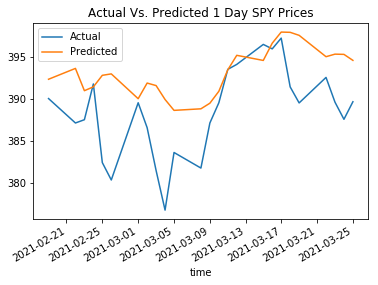

In [84]:
final_prediction = round(stocks['Predicted'].values[-1], 2)
chart = stocks.plot(title="Actual Vs. Predicted 1 Day SPY Prices")

This model predicts the price of SPY will be $394.57000732421875 at the close of tomorrow AxesSubplot(0.125,0.2;0.775x0.68)


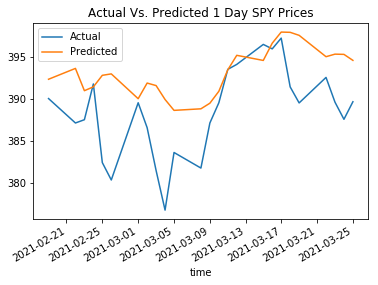

In [85]:
# Plot the real vs predicted prices as a line chart
output = print(f'This model predicts the price of SPY will be ${final_prediction} at the close of tomorrow', stocks.plot(title="Actual Vs. Predicted 1 Day SPY Prices"))